# EJERCICIOS

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Concatenate
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

2025-01-20 20:06:21.006154: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-20 20:06:21.014559: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-20 20:06:21.026121: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-20 20:06:21.029362: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-20 20:06:21.038546: I tensorflow/core/platform/cpu_feature_guar

## EJERCICIO 1


Supongamos que queremos predecir dos objetivos diferentes (por ejemplo, precio y categoría) a partir de dos conjuntos de características diferentes (por ejemplo, características visuales y características de texto de un producto).

* Características visuales: un conjunto de 128 características numéricas, que podrían representar, por ejemplo, valores de píxeles o características extraídas de imágenes.
* Características de texto: un conjunto de 256 características numéricas, representando posiblemente la codificación de texto o características lingüísticas.
* Precio (Salida 1): un valor numérico que representa el precio de un producto.
* Categoría (Salida 2): una etiqueta de categoría, que asumiremos que puede tomar 10 valores diferentes (por ejemplo, 10 categorías diferentes de productos).

Voy a generar datos aleatorios

In [2]:
# Generación de datos ficticios
num_muestras = 1000  # Número de muestras en el conjunto de datos

# Características visuales: 128 características numéricas
caracteristicas_visuales = np.random.rand(num_muestras, 128)

# Características de texto: 256 características numéricas
caracteristicas_texto = np.random.rand(num_muestras, 256)

# Precio (Salida 1): Valor numérico (por ejemplo, precio de un producto)
precio = np.random.rand(num_muestras, 1)

# Categoría (Salida 2): 10 categorías posibles (codificadas en one-hot)
categorias = np.random.randint(0, 10, size=(num_muestras, 1))
categorias_one_hot = tf.keras.utils.to_categorical(categorias, num_classes=10)

Divide los datos en entrenamiento y prueba

In [3]:
x1_full_train, x1_test, y1_full_train, y1_test = train_test_split(caracteristicas_visuales, categorias_one_hot, test_size=0.2, random_state=45)   # Características visuales  # Precio (Salida 1)
x2_full_train, x2_test, y2_full_train, y2_test = train_test_split(caracteristicas_texto, precio, test_size=0.2, random_state=45)      # Categoría (Salida 2)  # Características de texto
x1_train, x1_val, y1_train, y1_val = train_test_split(x1_full_train, y1_full_train, test_size=0.2, random_state=42)    
x2_train, x2_val, y2_train, y2_val = train_test_split(x2_full_train, y2_full_train, test_size=0.2, random_state=42)     

Construye el modelo:
* Crea dos ramas de entrada, una para cada tipo de características.
* Las ramas se fusionarán para predecir el precio.
* Una de las ramas se utilizará también para predecir la categoria.

El esquema es el siguiente:

<img src="../datos/esquema_modelo_funcional.png" alt="esquema modelo funcional"/>

In [4]:
# capas
input_visual = tf.keras.layers.Input(shape=x1_train.shape[1:])
input_texto = tf.keras.layers.Input(shape=x2_train.shape[1:])
rama_visual = tf.keras.layers.Dense(64, activation='relu')
rama_texto = tf.keras.layers.Dense(128, activation='relu')
combi = tf.keras.layers.Concatenate()
salida_precio = tf.keras.layers.Dense(1, name='salida_precio')
salida_categoria = tf.keras.layers.Dense(10, name='salida_cate')

# orden de las capas
hidden1_v = rama_visual(input_visual)
hidden1_t = rama_texto(input_texto)
concat = combi([hidden1_v,hidden1_t])
salida_p = salida_precio(concat)
salida_c = salida_categoria(hidden1_t)

# modelo
model = tf.keras.Model(inputs=[input_visual,input_texto], outputs=[salida_c,salida_p])

2025-01-20 18:40:22.069693: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-01-20 18:40:22.069725: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:135] retrieving CUDA diagnostic information for host: iadb-17
2025-01-20 18:40:22.069729: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:142] hostname: iadb-17
2025-01-20 18:40:22.069913: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:166] libcuda reported version is: 550.120.0
2025-01-20 18:40:22.069923: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] kernel reported version is: 550.120.0
2025-01-20 18:40:22.069925: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:249] kernel version seems to match DSO: 550.120.0


Comprueba creando una imagen del modelo que es igual que el que se pide

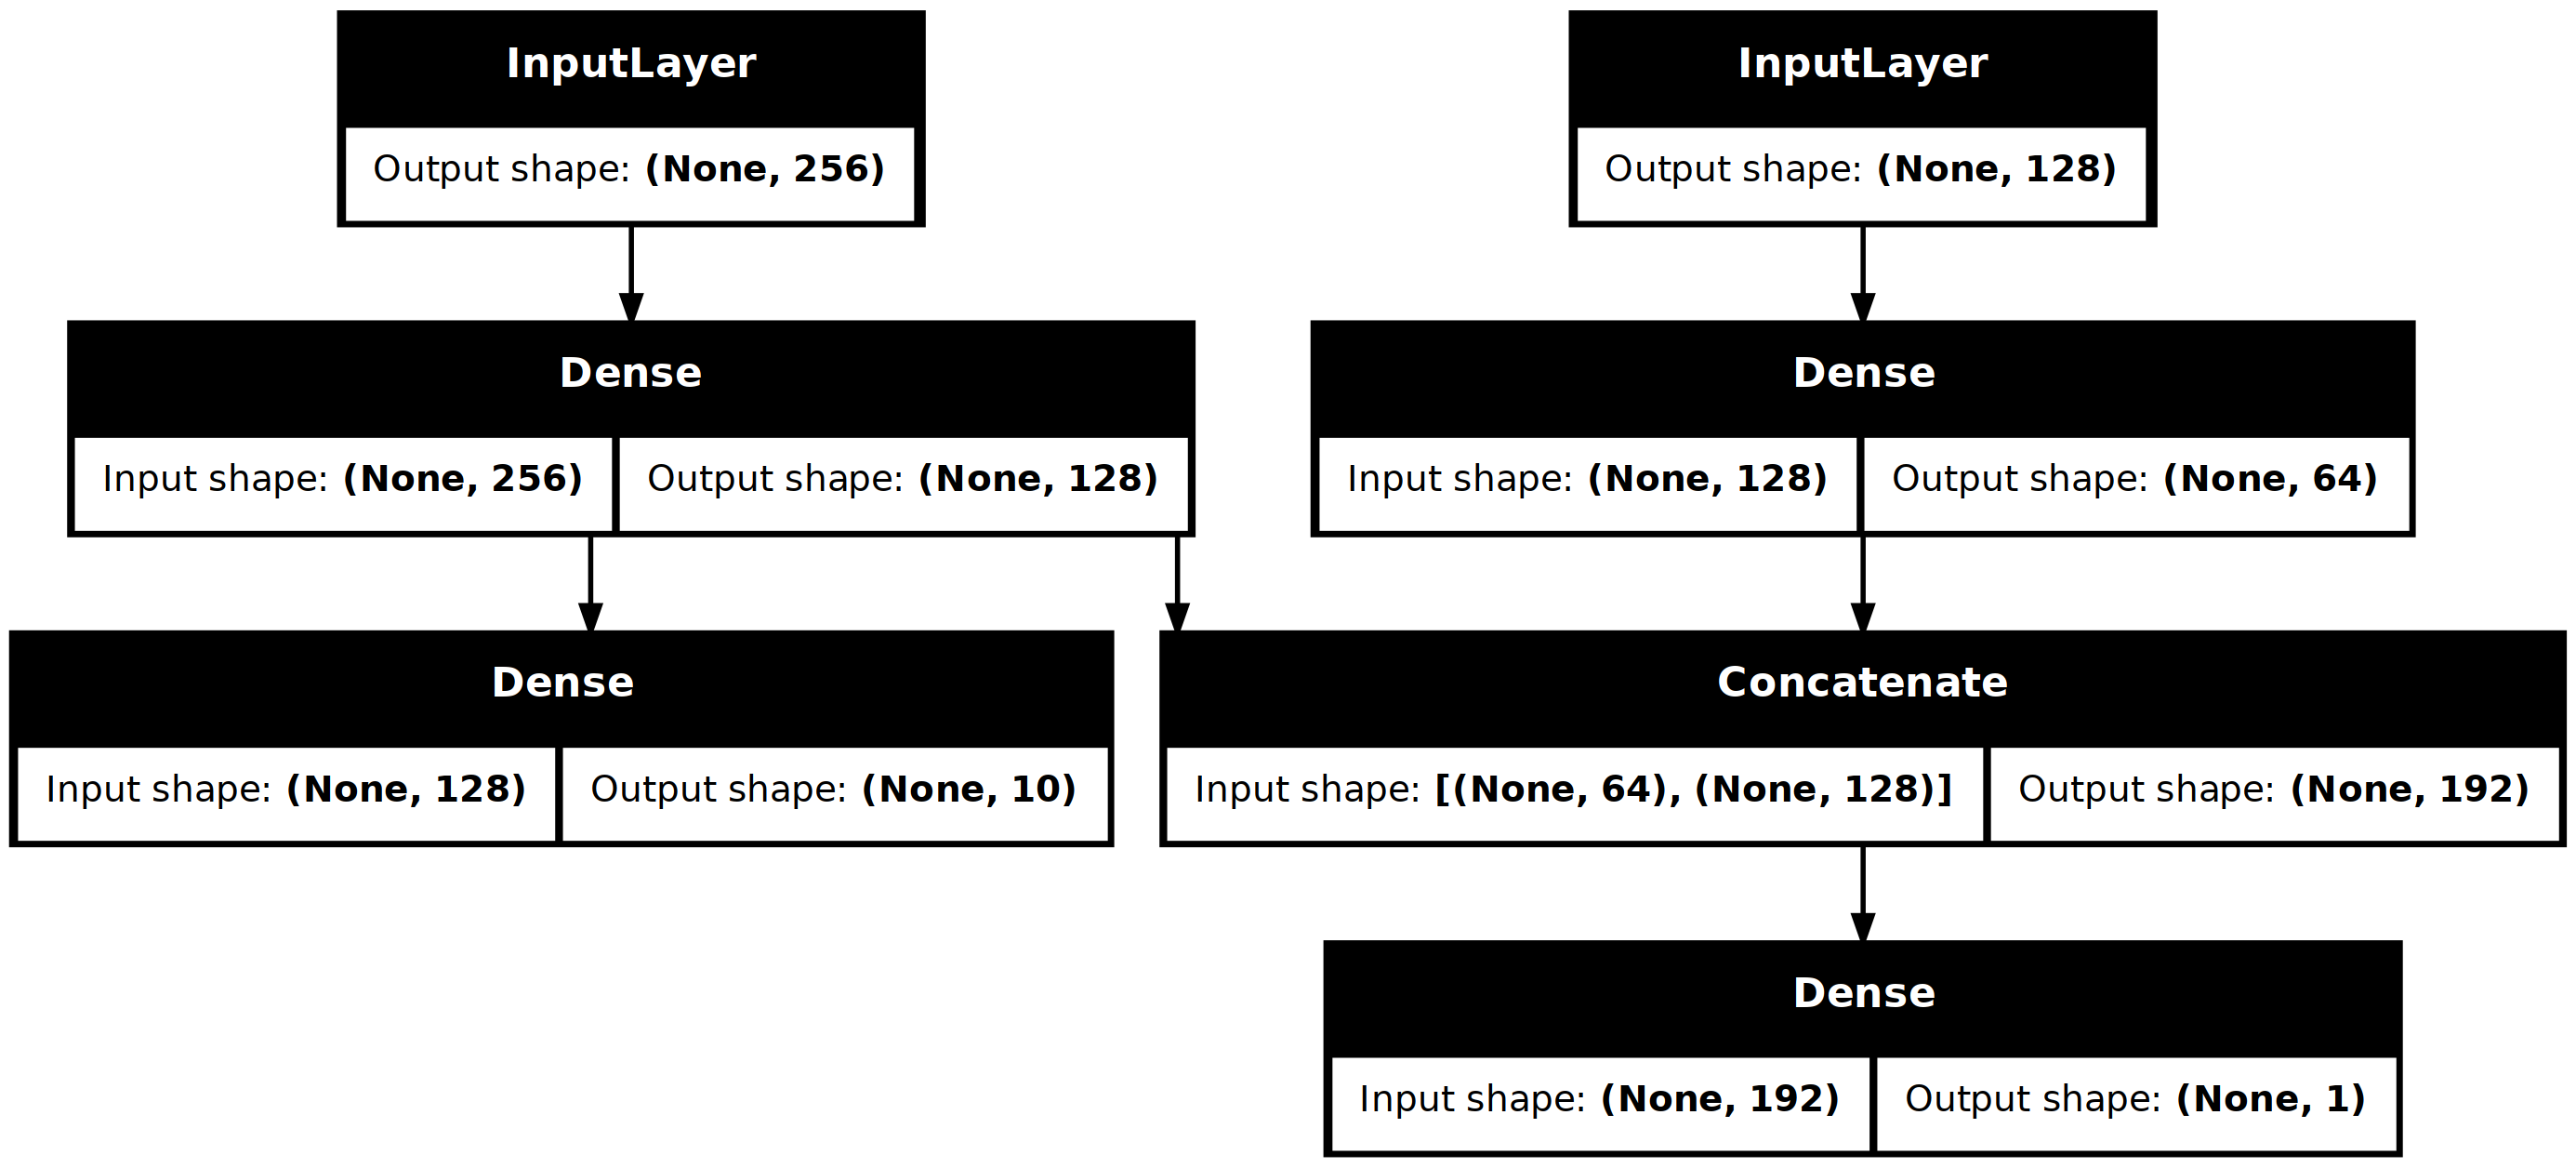

In [5]:
tf.keras.utils.plot_model(model, "recursos/imgs/modelo_4_7_1.png", show_shapes=True)

Compila el modelo especificando las pérdidas y métricas para cada salida (utiliza el optimizador Adam)

In [6]:
model.compile(loss={'salida_precio':'mse', 'salida_cate':'categorical_crossentropy'} ,   
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics={'salida_precio':['RootMeanSquaredError'], 'salida_cate':['accuracy']})


Entrena el modelo 

In [7]:
hist = model.fit((x1_train,x2_train), (y1_train, y2_train), epochs=30, validation_data=((x1_val,x2_val),(y1_val,y2_val)))

Epoch 1/30


/home/iabd/anaconda3/envs/iabd_3_9/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.1597 - salida_cate_accuracy: 0.0962 - salida_cate_loss: 7.7962 - salida_precio_RootMeanSquaredError: 0.5949 - salida_precio_loss: 0.3635 - val_loss: 9.4776 - val_salida_cate_accuracy: 0.0938 - val_salida_cate_loss: 9.3193 - val_salida_precio_RootMeanSquaredError: 0.3978 - val_salida_precio_loss: 0.1582
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0300 - salida_cate_accuracy: 0.0948 - salida_cate_loss: 8.8807 - salida_precio_RootMeanSquaredError: 0.3856 - salida_precio_loss: 0.1493 - val_loss: 7.0926 - val_salida_cate_accuracy: 0.0875 - val_salida_cate_loss: 6.9524 - val_salida_precio_RootMeanSquaredError: 0.3744 - val_salida_precio_loss: 0.1402
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.2359 - salida_cate_accuracy: 0.1244 - salida_cate_loss: 8.1104 - salida_precio_RootMeanSquaredError: 0.3542 - salida_precio_loss: 0.1255 - val_loss: 7.5924 - val_salida_cate_accuracy: 0.0875 - val_salida_cate_loss: 7.4559 

Evalúa el modelo en el conjunt de pruebas

In [8]:
mse_test = model.evaluate((x1_test, x2_test), (y1_test,y2_test))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.5720 - salida_cate_accuracy: 0.0669 - salida_cate_loss: 6.5264 - salida_precio_RootMeanSquaredError: 0.3602 - salida_precio_loss: 0.1276 


/home/iabd/anaconda3/envs/iabd_3_9/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(


## EJERCICIO 2

El objetivo de este ejercicio es entrenar un modelo en un subconjunto de clases (Modelo A) y luego usar este modelo para entrenar otro modelo en un subconjunto diferente de clases (Modelo B), primero sin y luego con el conocimiento transferido del Modelo A.

Carga los datos de CIFAR-10, representa alguna de sus imágenes con sus etiquetas, haz una lista con las etiquetas que tiene (busca en internet) y normaliza los datos dividiendo entre 255.0.

Divide los datos en conjuntos de entrenamiento, pruebas y validación para el modelo A y para el modelo B:
* El modelo A utiliza las clases "avión", "automóvil", "pájaro" y "gato"
* El modelo B utiliza las clases "ciervo", "perro", "rana" y "caballo" 

In [ ]:
datos = tf.keras.datasets.cifar10.load_data()

# Dividimos las tuplas en x e y
(x_train_full, y_train_full), (x_test_full, y_test_full) = datos

# 50,000 entrenamiento
x_train = x_train_full[:50000]
y_train = y_train_full[:50000]

# 5,000 validación
x_val = x_test_full[:5000]
y_val = y_test_full[:5000]

# 5,000 prueba
x_test = x_test_full[5000:10000]
y_test = y_test_full[5000:10000]

((array([[[[ 59,  62,  63],
           [ 43,  46,  45],
           [ 50,  48,  43],
           ...,
           [158, 132, 108],
           [152, 125, 102],
           [148, 124, 103]],
  
          [[ 16,  20,  20],
           [  0,   0,   0],
           [ 18,   8,   0],
           ...,
           [123,  88,  55],
           [119,  83,  50],
           [122,  87,  57]],
  
          [[ 25,  24,  21],
           [ 16,   7,   0],
           [ 49,  27,   8],
           ...,
           [118,  84,  50],
           [120,  84,  50],
           [109,  73,  42]],
  
          ...,
  
          [[208, 170,  96],
           [201, 153,  34],
           [198, 161,  26],
           ...,
           [160, 133,  70],
           [ 56,  31,   7],
           [ 53,  34,  20]],
  
          [[180, 139,  96],
           [173, 123,  42],
           [186, 144,  30],
           ...,
           [184, 148,  94],
           [ 97,  62,  34],
           [ 83,  53,  34]],
  
          [[177, 144, 116],
           [16

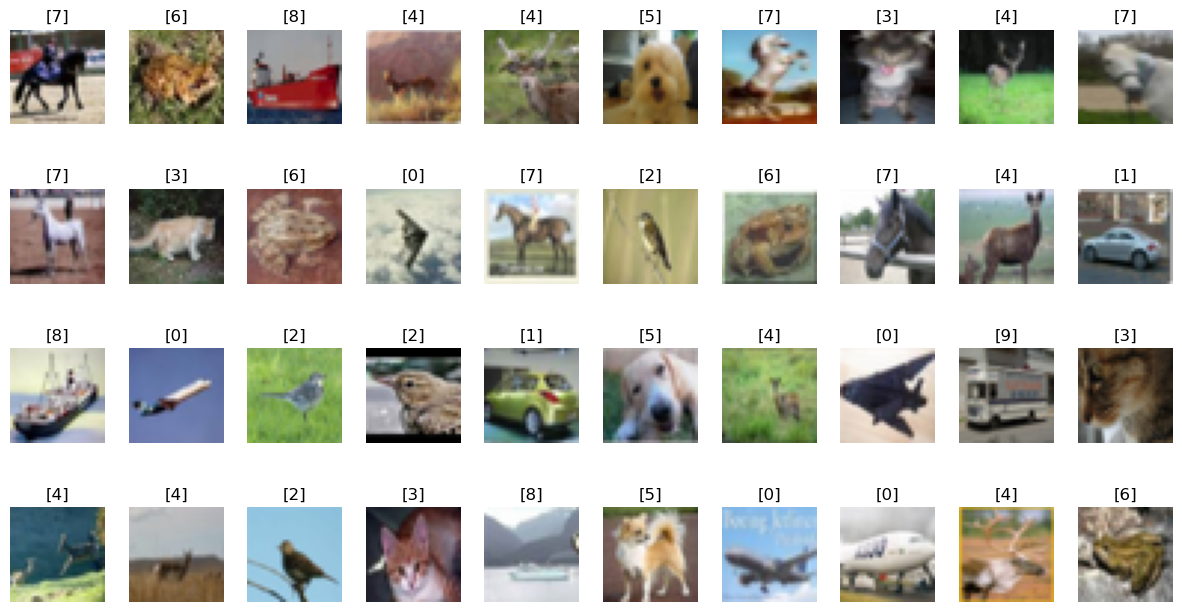

In [16]:
fig,ax = plt.subplots(4,10, figsize=(15,8))
ax = ax.flatten()
# aniadimos las imagenes al grafico
for i in range(40):
    ax[i].set_title(y_test[i])
    ax[i].imshow(x_test[i], cmap="gray")
    ax[i].axis("off") 
plt.subplots_adjust(wspace=0.25, hspace=0.15)   # ajusta los margenes para separar las imágenes 
plt.show()


In [ ]:
soluciones = {0: 'avion', 1: 'coche',2: 'pajaro', 3: 'gato',4: 'ciervo', 
            5: 'perro',6: 'rana', 7: 'caballo',8: 'barco', 9: 'camiion'}

In [8]:
# valores de y
values,count = np.unique(y_train,return_counts=True)
for y, cant in zip(values,count):
    print(y,' --> ',cant)
len(y_train)

0  -->  5000
1  -->  5000
2  -->  5000
3  -->  5000
4  -->  5000
5  -->  5000
6  -->  5000
7  -->  5000
8  -->  5000
9  -->  5000


50000

In [ ]:
# normalizar  /255
x_train, x_val, x_test = x_train/255. , x_val/255. , x_test/255. 

Entrena el Modelo A       
- El modelo A utiliza las clases "avión", "automóvil", "pájaro" y "gato"

In [17]:
# crear capas
tf.random.set_seed(42)
model_A = tf.keras.Sequential([
    tf.keras.layers.Input(shape=x_train.shape[:1]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(4, activation="softmax")
])

# compilar
model_A.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

SyntaxError: invalid syntax (3832673390.py, line 13)

Entrenar el Modelo B desde 0    
- El modelo B utiliza las clases "ciervo", "perro", "rana" y "caballo"

Entrenar el Modelo B utilizando las capas aprendidas del Modelo A (excepto la capa de salida)

Evaluar los dos modelos para el conjunto de datos B en el conjunto de pruebas

¿En este caso merece la pena?